In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import itertools
from tqdm.auto import tqdm

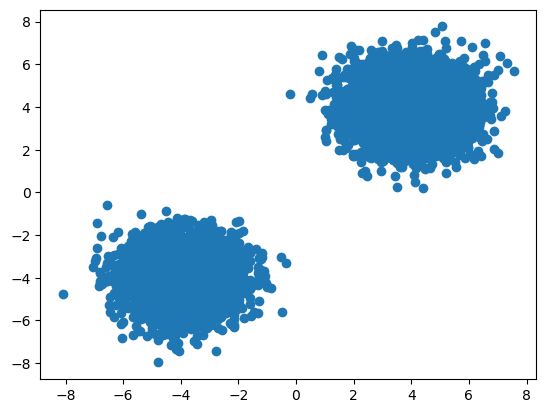

In [2]:
import torch.distributions as dist

data_distribution = torch.distributions.mixture_same_family.MixtureSameFamily(
    torch.distributions.Categorical(torch.tensor([1, 2]).float()),
    dist.MultivariateNormal(
        torch.tensor([[-4, -4], [4, 4]]).float(), # 各成分の平均
        torch.tensor([[[1, 0], [0, 1]],
                     [[1, 0], [0, 1]]]).float()
    )
)


dataset = data_distribution.sample(torch.Size([10000, 1]))
# tensor.Size([1000, 1, 2]) to tensor.Size([1000, 2])
dataset = dataset.view(10000, 2)
#dataset = data_distribution.sample(torch.Size([1000, 1]))


#sns.histplot(dataset[:,0])
#plt.show()
plt.scatter(dataset.view(10000, 2)[:,0], dataset.view(10000, 2)[:,1])

このプロットはデータの分布を表している、 すなわち$q(x_0)$である。見てわかるように、我々のトレーニングデータセットは2つのガウス分布の混合からのサンプルを含み、右側の成分は2倍の頻度でサンプリングされています。

拡散過程の分布は次で与えられる；

\begin{align}
q(x_{1:T}|x_0) := \Pi_{t=1}^{T}q(x_t|x_{t-1})
\end{align}

ただし、各ステップでガウスノイズを付加していく；

\begin{align}
q(x_t|x_{t-1}) = \mathcal{N}(x_t|\sqrt{1 - \beta_t}x_{t-1};\beta_t I)
\end{align}

この分布の平均と分散は、拡散プロセス後の$x_T$の最終分布が平均0、単位分散のガウス分布になるように設定されたものである。

この過程はループで簡単に実装できる

In [3]:
TIME_STEPS = 300
# TIME_STEPS = 250

"""
BETAをいろいろためしたい
"""
BETA = 0.02 # 時間に関わらず固定

In [4]:
# CPU

def do_diffusion(data, steps=TIME_STEPS, beta=BETA):
    # perform diffusion
    # returns a list of q(x(t)) and x(t)
    # starting from t=0 (i.e., the dataset)

    distributions, samples = [None], [data]
    xt = data
    for t in range(steps):

        q = torch.distributions.MultivariateNormal(
            np.sqrt(1 - beta) * xt,
            np.sqrt(beta) * torch.tensor([[[1, 0], [0, 1]]])
        )

        
        xt = q.sample()

        distributions.append(q)
        samples.append(xt)

    return distributions, samples

In [5]:
# GPU

device = torch.device("cuda" if torch.cuda.is_available else "cpu")

def do_diffusion(data, steps=TIME_STEPS, beta=BETA, device=device):
    # perform diffusion
    # returns a list of q(x(t)) and x(t)
    # starting from t=0 (i.e., the dataset)

    distributions, samples = [None], [data]
    xt = data
    xt = xt.to(device)
    for t in range(steps):

        q = torch.distributions.MultivariateNormal(
            np.sqrt(1 - beta) * xt,
            np.sqrt(beta) * torch.tensor([[[1, 0], [0, 1]]], device=device)
        )

        """
        q = torch.distributions.Normal(
            np.sqrt(1 - beta) * xt,
            np.sqrt(beta)
        )
        """
        xt = q.sample()
        xt = xt.to(device)

        distributions.append(q)
        samples.append(xt)

    return distributions, samples

In [6]:
_, samples = do_diffusion(dataset)

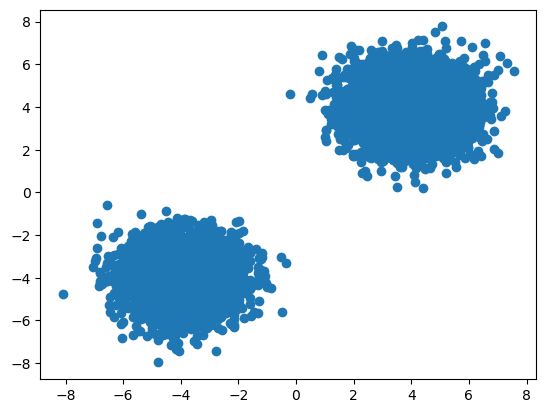

In [7]:
plt.scatter(x=samples[0][:,0], y=samples[0][:,1])

拡散過程を視覚化するために、時間をX軸に、拡散したサンプルをY軸にプロットします。

ご覧の通り、ノイズを加えると徐々にデータ分布からのサンプルが正規分布$\mathcal{N}(0,1)$に近づいていくのがわかる。これでこの過程を逆転させるモデルを訓練する準備が整った。

# Training

できるだけ単純に保つために、ここでは論文の方程式3における損失を使用しており、後に提示される最適化は複雑な実世界の分布にのみ役割を果たします。
この場合、拡散モデルはまず訓練例を汚染することによって訓練され、その後、汚染プロセスの各ステップでノイズの多い例からよりクリーンな例を再構築しようとします。損失は負の対数尤度の上限です：

\begin{align}
L := \mathbb{E}\left[- \log p(x_T) - \sum_{t=1}^{T}\log\frac{p_{\theta}(x_{t-1}|x_t)}{q(x_t|x_{t-1})}\right]
\end{align}

ただし、生成モデル（逆拡散モデル）は

\begin{align}
p_{\theta}(x_{t-1}|x_t) := \mathcal{N}(x_{t-1};\mu_{\theta}(x_t,t), \Sigma_{\theta}(x_t,t))
\end{align}

2つのニューラルネットワーク、$\mu_{\theta}$と$\Sigma_{\theta}$を訓練していることに注意してください。これらはノイズの多いサンプル$x_t$とステップ$t$を入力として受け取り、ノイズが加えられる前のサンプル$x_{t-1}$の分布のパラメータを予測しようとします。直感的には、これらのネットワークを訓練して、未汚染の例$x_{t-1}$を観測する予測確率を最大化することです。つまり、損失の中の項$p_{\theta}(x_{t-1}|x_t)$を、各拡散ステップで最大化します。覚えておいてください、$x_t$は以前$x_{t-1}$にノイズを加えることによって生成されました。ネットワークはノイズを元に戻す方法を学ばなければなりません。損失に含まれる他の項$q(x_t|x_{t-1})$は、一定であるため、良い生成モデルを学ぶためには必要ありませんが、「完璧な」生成モデルが損失0を達成するための「参照枠」として役立ちます。
損失は以下の関数で実装されています。この関数は、訓練サンプルの完全な拡散軌跡と、逆プロセスを定義する2つのニューラルネットワークを必要とします：

In [8]:
# CPU

def compute_loss(forward_distributions, forward_samples, mean_model, var_model):
    # here we compute the loss
    # forward = q, reverse = p

    # loss for x(T)
    p = torch.distributions.MultivariateNormal(
        torch.zeros(forward_samples[0].shape),
        torch.tensor([[[1, 0], [0, 1]]]).float()
    )
    # 損失関数1項目：-logp(x(T))の計算
    loss = -p.log_prob(forward_samples[-1]).mean()

    for t in range(1, len(forward_samples)):
        xt = forward_samples[t]# x(t)
        xprev = forward_samples[t-1] # x(t-1)
        q = forward_distributions[t] # q(x(t)|x(t-1))

        # normalize t between 0 and 1 and add it as a new column
        # to the inputs of the mu and sigma networks
        # tensor.Size([1000, 2]) to tensor.Size([1000, 3]) 時刻情報を連結
        xin = torch.cat(
        (xt, (t/len(forward_samples)) * torch.ones(xt.shape[0],1)),
        dim=1
        )

        # compute p(x(t-1)|x(t))
        mu = mean_model(xin)
        sigma = var_model(xin)
        p = torch.distributions.MultivariateNormal(mu, sigma)

        # 損失関数2項目：log p(x(t-1)|x(t)) / q(x(t)|q(t-1))の計算
        loss -= torch.mean(p.log_prob(xprev))
        loss += torch.mean(q.log_prob(xt))


    return loss / len(forward_samples)

In [10]:
# GPU用

def compute_loss(forward_distributions, forward_samples, mean_model, var_model, device):
    # here we compute the loss
    # forward = q, reverse = p

    # loss for x(T)
    p = torch.distributions.MultivariateNormal(
        torch.zeros(forward_samples[0].shape, device=device),
        torch.tensor([[[1, 0], [0, 1]]], device=device).float()
    )
    # 損失関数1項目：-logp(x(T))の計算
    loss = -p.log_prob(forward_samples[-1]).mean()

    for t in range(1, len(forward_samples)):
        xt = forward_samples[t]# x(t)
        xt = xt.to(device)
        xprev = forward_samples[t-1] # x(t-1)
        xprev = xprev.to(device)
        q = forward_distributions[t] # q(x(t)|x(t-1))

        # normalize t between 0 and 1 and add it as a new column
        # to the inputs of the mu and sigma networks
        # tensor.Size([1000, 2]) to tensor.Size([1000, 3]) 時刻情報を連結
        xin = torch.cat(
        (xt, (t/len(forward_samples)) * torch.ones(xt.shape[0],1, device=device)),
        dim=1
        )
        xin = xin.to(device)

        # compute p(x(t-1)|x(t))
        mu = mean_model(xin)
        mu = mu.to(device)
        sigma = var_model(xin)
        sigma = sigma.to(device)
        p = torch.distributions.MultivariateNormal(mu, sigma)

        # 損失関数2項目：log p(x(t-1)|x(t)) / q(x(t)|q(t-1))の計算
        loss -= torch.mean(p.log_prob(xprev))
        loss += torch.mean(q.log_prob(xt))
        loss = loss.to(device)


    return loss / len(forward_samples)

## Implemention1

In [11]:
import torch.nn as nn

class VarModel(nn.Module):
    def __init__(self):
        super(VarModel, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(4, 4)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softplus(x)

        # 正定値対称行列に変換
        # コレスキー分解を無理やり作る非連続変形
        # のため勾配が逆伝播しにくく学習が安定しないかもしれない
        L = torch.zeros(x.size(0), 2, 2)
        L[:, 0, 0] = x[:, 0]
        L[:, 1, 0] = x[:, 1]
        L[:, 1, 1] = x[:, 2]

        # 行列 L L^T を計算
        covariance_matrix = torch.bmm(L, L.transpose(1, 2))
        return covariance_matrix

In [12]:
import os

os.getcwd()

'/home/hashikami/anaconda3/envs/Diff/content'

In [13]:
mean_model = torch.nn.Sequential(
    torch.nn.Linear(3,4), torch.nn.ReLU(),
    torch.nn.Linear(4,2)
)
var_model = VarModel()

In [ ]:
# checkpoint読み込み

mean_model.load_state_dict(torch.load("mean_model_checkpoint.pth"))
var_model.load_state_dict(torch.load("var_model_checkpoint.pth"))

<All keys matched successfully>

いよいよ訓練しよう

## Implementation2

In [9]:
import torch.nn as nn

class MeanModel(nn.Module):
    def __init__(self):
        super(MeanModel, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 2)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [11]:
class VarModel(nn.Module):
    def __init__(self):
        super(VarModel, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 4)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softplus(x)

        """
        # 正定値対称行列にしなければならない
        x = x.view(-1, 2, 2) # ここ重要 (2, 2)? (-1, 2, 2)? A. 後者
        """

        # 正定値対称行列に変換
        # コレスキー分解を無理やり作る非連続変形
        # のため勾配が逆伝播しにくく学習が安定しないかもしれない
        L = torch.zeros(x.size(0), 2, 2)
        L[:, 0, 0] = x[:, 0]
        L[:, 1, 0] = x[:, 1]
        L[:, 1, 1] = x[:, 2]

        # 行列 L L^T を計算
        covariance_matrix = torch.bmm(L, L.transpose(1, 2))
        return covariance_matrix

In [12]:
mean_model = MeanModel()
var_model = VarModel()

## Optimize

In [13]:
optim = torch.optim.AdamW(
    itertools.chain(mean_model.parameters(), var_model.parameters()),
    lr = 1e-2, weight_decay=1e-6,
)

In [ ]:
loss_histry = []
epochs = 1000
bar = tqdm(range(epochs))

# GPU or CPU
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
mean_model = mean_model.to(device)
var_model = var_model.to(device)

for e in bar:
    forward_distributions, forward_samples = do_diffusion(dataset)

    forward_samples = [sample.to(device) for sample in forward_samples]
    optim.zero_grad()
    loss = compute_loss(
    forward_distributions, forward_samples, mean_model, var_model)
    loss.backward()
    optim.step()

    bar.set_description(f'Loss: {loss.item():4f}')
    loss_histry.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
# checkpointの保存関数
def save_checkpoint(mean_model, var_model, optimizer, epoch, loss, filename='checkpoint.pth'):
  checkpoint = {
      'mean_model_state_dict': mean_model.state_dict(),
      'var_model_state_dict': var_model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'epoch': epoch,
      'loss': loss
  }
  torch.save(checkpoint, filename)

def load_checkpoint(mean_model, var_model, optimizer, filename='checkpoint.pth'):
  checkpoint = torch.load(filename)
  mean_model.load_state_dict(checkpoint['mean_model_state_dict'])
  var_model.load_state_dict(checkpoint['var_model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  return mean_model, var_model, optimizer, epoch, loss

In [18]:
mean_model = MeanModel()
var_model = VarModel()
mean_model, var_model, optimizer, epoch, loss = load_checkpoint(mean_model, var_model, optim, filename="checkpoint/checkpoint2.pth")
mean_model = mean_model.to(device)
var_model = var_model.to(device)

In [19]:
# checkpoint作成用 CPU
loss_histry = []
epochs = 3500
start_epoch = 0

# checkpointからスタート
mean_model, var_model, optim, start_epoch, loss = load_checkpoint(mean_model, var_model, optim, filename='checkpoint/checkpoint.pth')


device = 'cpu'
mean_model = mean_model.to(device)
var_model = var_model.to(device)

bar = tqdm(range(start_epoch, epochs))
save_interval = 10


for e in bar:
    forward_distributions, forward_samples = do_diffusion(dataset)

    forward_samples = [sample.to(device) for sample in forward_samples]
    optim.zero_grad()
    loss = compute_loss(
    forward_distributions, forward_samples, mean_model, var_model)
    loss.backward()
    optim.step()

    bar.set_description(f'Loss: {loss.item():4f}')
    loss_histry.append(loss.item())

    if (e + 1) % save_interval == 0:
      save_checkpoint(mean_model, var_model, optim, e + 1, loss.item(), filename="checkpoint/checkpoint.pth")

  0%|          | 0/500 [00:00<?, ?it/s]

In [24]:
# checkpoint作成用 GPU
loss_histry = []
epochs = 3500
start_epoch = 0

# checkpointからスタート
#mean_model, var_model, optim, start_epoch, loss = load_checkpoint(mean_model, var_model, optim, filename='checkpoint/checkpoint.pth')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean_model = mean_model.to(device)
var_model = var_model.to(device)

bar = tqdm(range(start_epoch, epochs))
save_interval = 10


for e in bar:
    forward_distributions, forward_samples = do_diffusion(dataset)

    forward_samples = [sample.to(device) for sample in forward_samples]
    optim.zero_grad()
    loss = compute_loss(
    forward_distributions, forward_samples, mean_model, var_model, device=device)
    loss.backward()
    optim.step()

    bar.set_description(f'Loss: {loss.item():4f}')
    loss_histry.append(loss.item())

    if (e + 1) % save_interval == 0:
      save_checkpoint(mean_model, var_model, optim, e + 1, loss.item(), filename="checkpoint/checkpoint2.pth")

  0%|          | 0/3500 [00:00<?, ?it/s]

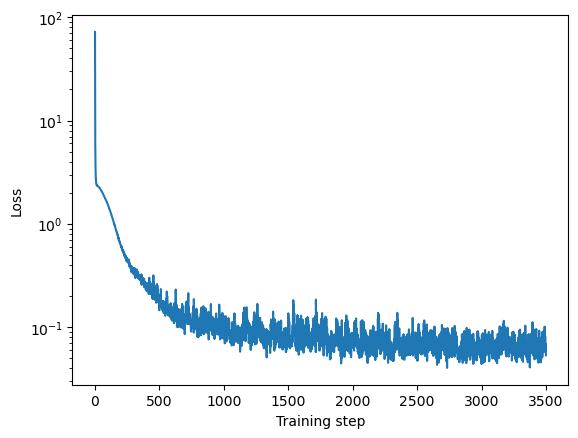

In [25]:
plt.plot(loss_histry)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training step')
plt.show()

# Sample generation

最終的に、訓練されたニューラルネットワークを使用して、データ分布から新しいサンプルを生成できます。
このプロセスは、以前の拡散プロセスと非常に似ていますが、ここでは通常分布から始めて、予測された平均と分散を使用して徐々に「ノイズ」を取り除く点が異なります。

In [19]:
# CPU

def sample_reverse(mean_model, var_model, count, steps=TIME_STEPS):
    """
    count: サンプル数
    """
    p = torch.distributions.MultivariateNormal(torch.zeros(count, 2,), torch.eye(2).repeat(count, 1, 1))
    xt = p.sample()
    sample_histry = [xt]
    for t in range(steps, 0, -1):
        #xin = torch.cat((xt, t * torch.ones(xt.shape) / steps), dim=1)
        xin = torch.cat((xt, t * torch.ones(xt.shape[0], 1) / steps), dim=1)
        p = torch.distributions.MultivariateNormal(
        mean_model(xin), var_model(xin)
        )

        xt = p.sample()
        sample_histry.append(xt)

    return sample_histry

In [20]:
# GPU

def sample_reverse(mean_model, var_model, count, steps=TIME_STEPS, device=device):
    """
    count: サンプル数
    """
    p = torch.distributions.MultivariateNormal(torch.zeros(count, 2, device=device), torch.eye(2, device=device).repeat(count, 1, 1))
    xt = p.sample()
    xt = xt.to(device)
    sample_histry = [xt]
    for t in range(steps, 0, -1):
        #xin = torch.cat((xt, t * torch.ones(xt.shape) / steps), dim=1)
        xin = torch.cat((xt, t * torch.ones(xt.shape[0], 1, device=device) / steps), dim=1)
        xin = xin.to(device)
        p = torch.distributions.MultivariateNormal(
        mean_model(xin).to(device), var_model(xin).to(device)
        )

        xt = p.sample()
        xt = xt.to(device)
        sample_histry.append(xt)

    return sample_histry

In [21]:
reverse_samples = sample_reverse(mean_model, var_model, 1000, steps=TIME_STEPS)

In [22]:
# for GPU
reverse_samples = [sample.cpu() for sample in reverse_samples]

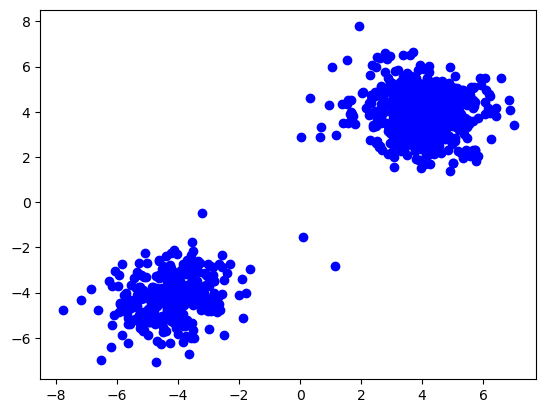

In [26]:

plt.scatter(x=reverse_samples[300][:,0], y=reverse_samples[300][:,1], c="blue")

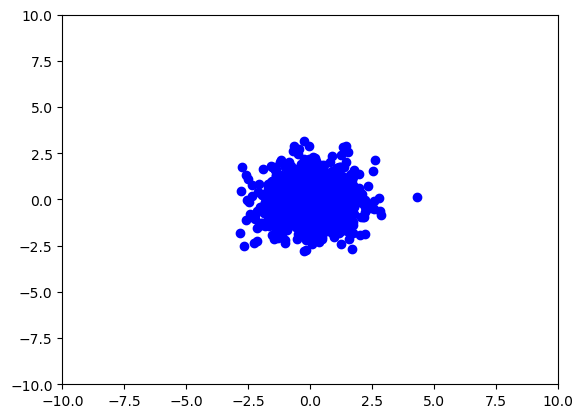

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import norm

# frame数
num_frames = 300

# 図と軸の作成
fig, ax = plt.subplots()
scat = ax.scatter(x=reverse_samples[0][:,0], y=reverse_samples[0][:,1], c="blue")

# 軸の範囲を設定
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

# アニメーションの更新関数
def update(frame):
    scat.set_offsets(np.c_[reverse_samples[frame], reverse_samples[frame]])
    return scat,

# アニメーションの作成
ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=True)

# アニメーションの表示
plt.show()

# アニメーションをGIFとして保存（オプション）
ani.save('distribution_animation1.gif', writer='pillow')
